# What about the performance?

Fun fact: you can derive the effectiveness of feedback control from that transfer matrix. Looking at the last row which represents the transfers from the reference and disturbances to the tracking error, $e$. The smaller this error, the better the feedback control is performing. Now also note that every element in this last row is right multiplied with $S$, meaning that smaller magnitudes of $S$ result in smaller tracking errors. So
- $|S(s)| < 1 \rightarrow $ disturbances are attenuated/rejected (this is good),
- $|S(s)| = 1 \rightarrow $ equivalent to open loop control (meh),
- $|S(s)| > 1 \rightarrow $ disturbances are amplified (this is bad).

We've looked at controller performance before with the gain, phase, and stability margins. Of course these are still valid and we'll build further on this. Just to reframe that theory, we have to define the cross-over frequencies $\omega_\text{gc}\leftarrow|L(\omega_\text{gc})|=1$ and $\omega_\text{pc}\leftarrow\angle L(\omega_\text{pc})=\pm 180^\circ$ for the gain and phase cross-overs. Then the gain margin GM $=1/|L(\omega_\text{pc})|$ and phase margin PM $=180^\circ - |\angle L(\omega_\text{gc})|$.

With our new theory we can also define the closed loop bandwidth, $\omega_\text{B}$, of our controlled system! This is a measure of until what frequency we can reject disturbances and it's defined as the frequency where $|T(s)|$ first crosses $\frac{1}{\sqrt2}\approx0.707\approx -3$ dB from above.

Now for the stability margin, $s_m$, that we defined earlier as the minimal distance between $L(s)$ and the point -1. Equivalently, this is the minimum of $|1 + L(s)|$, which coincidentally is the denominator of $S$.
Therefore the stability margin occurs when the sensitivity function magnitude is the largest. Utilising that property, we define
$$ M_S = \max |S(s)| = \frac{1}{s_m} .$$
So we have to perform some geometry magic, but to explain that we need an exampe Nyquist plot

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")
from helperFunctions import *
setPlotStyle()


<IPython.core.display.Javascript object>

Gain margin = 2.28
Phase margin = 34.19 degrees
Stability margin = 0.39


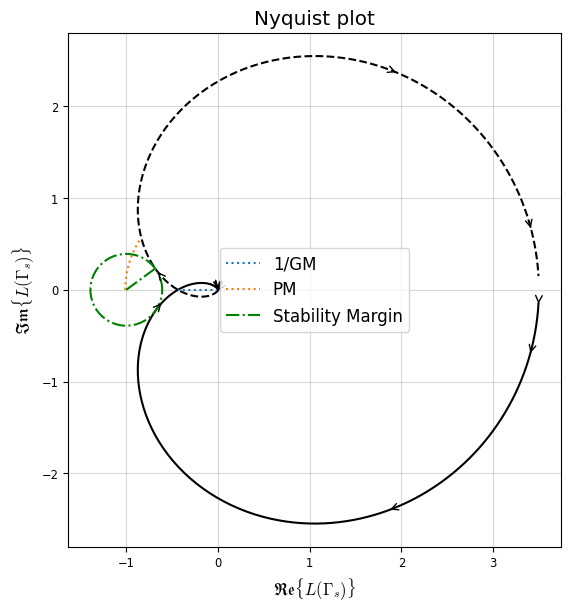

In [2]:
L2 = lambda s :  1.2 / (s+.7)**3

OM = np.logspace(-2, 2, 700)
S = OM*1j

L2_eval1 = L2(S)
L2_eval2 = L2(np.flip(-S))

L2mag_eval1 = np.abs(L2_eval1)
L2ph_eval1 = unwrap_angle(np.angle(L2_eval1, deg=True))
L2ph_eval1 %= 360

fig, ax = plt.subplots(num="Performance")

drawContour(ax, L2_eval1, c='k', ls='-')
drawContour(ax, L2_eval2, c='k', ls='--')

ax.set(title="Nyquist plot", aspect='equal',
          xlabel=r"$\mathfrak{Re}\{L(\Gamma_s)\}$", ylabel=r"$\mathfrak{Im}\{L(\Gamma_s)\}$")

## Determine gain margin
idx_g_m = np.abs((L2ph_eval1 - 180.)).argmin()
g_m = 1/L2mag_eval1[idx_g_m]
l1, = ax.plot([0, -L2mag_eval1[idx_g_m]], [0,0], c='C0', ls=':', label="1/GM")

print(f"Gain margin = {g_m:1.2f}")

## Determine phase margin
idx_phi_m_candidates = [idx for idx in range(L2mag_eval1.size - 1) if (L2mag_eval1[idx]-1) * (L2mag_eval1[idx+1]-1) < 0. 
                        and abs(L2ph_eval1[idx]) >= 90. ]
idx_phi_m = idx_phi_m_candidates[0]
phi_m = np.abs(180 + L2ph_eval1[idx_phi_m])
a = L2mag_eval1[idx_phi_m] * np.exp(np.linspace(0, np.asin(np.sin(phi_m * np.pi / 180.)))*1j)
l2, = ax.plot(-a.real, abs(a.imag), c='C1', ls=':', label="PM")
print(f"Phase margin = {np.asin(np.sin(phi_m * np.pi / 180.)) * 180. / np.pi:1.2f} degrees")

## Determine stability margin
idx_s_m = np.abs(L2_eval1 + 1).argmin()
s_m = np.abs(L2_eval1 + 1).min()
l3, = ax.plot([-1, L2_eval1[idx_s_m].real],
           [0, abs(L2_eval1[idx_s_m].imag)],
           'g-.', label="Stability Margin")
SMcirc = s_m * np.exp(np.linspace(0,2*np.pi) * 1j)
ax.plot(SMcirc.real - 1, SMcirc.imag,
           'g-.', label="Stability Margin")

ax.legend(handles=[l1,l2,l3])
print(f"Stability margin = {s_m:1.2f}")

display(fig)


Lets have a gander at what this plot tells us, starting with the gain margin. We can say for sure that the Nyquist plot on the real axis is *at least* as far away as $s_m$, otherwise that would be the stability margin. So we have $s_m \leq 1 - \frac{1}{\text{GM}}$ from that statement, and some rewriting gives
$$ s_m \leq 1 - \frac{1}{\text{GM}} \rightarrow 1 - s_m \geq \frac{1}{\text{GM}} \rightarrow \text{GM} \geq \frac{1}{1 - s_m} .$$
Coupling back to $M_S$:
$$ \frac{1}{1 - s_m} = \frac{M_S}{M_S - 1} \leq \text{GM}.$$

Now the phase margin is a tad more annoying, because it actually involves triangles and we need some extra lines. (Stolen from: Skogestad p.35)





<IPython.core.display.Javascript object>

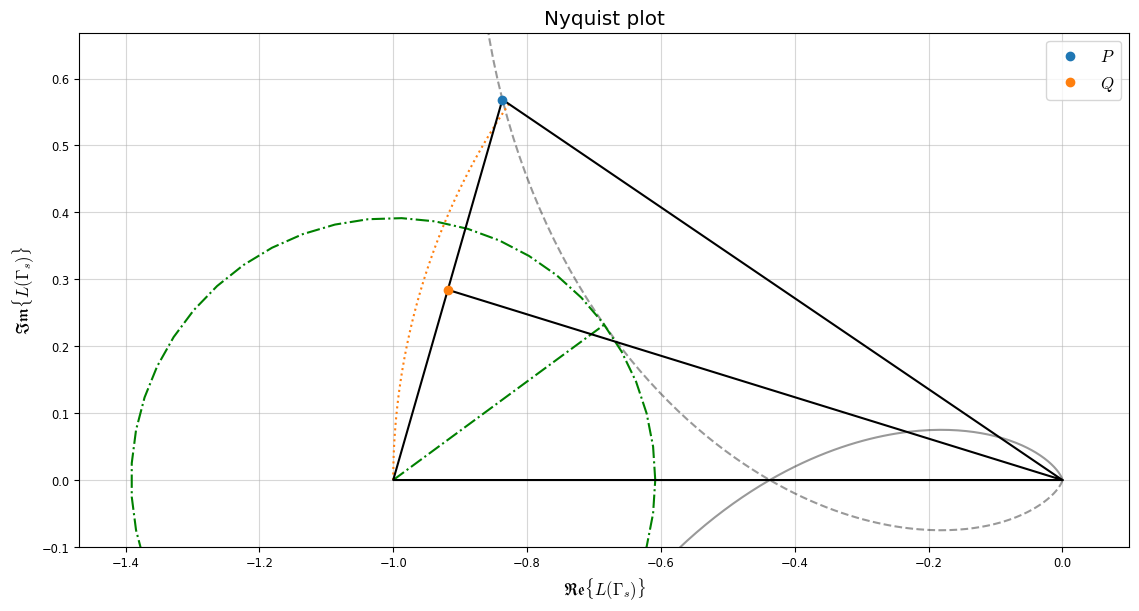

In [3]:
PM = L2_eval1[idx_phi_m].real + abs(L2_eval1[idx_phi_m].imag) * 1j
SM = L2_eval1[idx_s_m].real + abs(L2_eval1[idx_s_m].imag) * 1j

# Redraw figure and zoom to relevant part
fig, ax = plt.subplots(num="Performance - Phase Margin bounds")

ax.set(title="Nyquist plot", aspect='equal',
          xlabel=r"$\mathfrak{Re}\{L(\Gamma_s)\}$", ylabel=r"$\mathfrak{Im}\{L(\Gamma_s)\}$")

ax.plot(L2_eval1.real, L2_eval1.imag, c='k', ls='-', alpha=.4)
ax.plot(L2_eval2.real, L2_eval2.imag, c='k', ls='--', alpha=.4)
ax.plot(-a.real/abs(a), abs(a.imag)/abs(a), c='C1', ls=':', label="PM")
ax.plot([-1, SM.real],
        [0, SM.imag],
        'g-.', label="Stability Margin")
SMcirc = s_m * np.exp(np.linspace(0,2*np.pi) * 1j)
ax.plot(SMcirc.real - 1, SMcirc.imag,
           'g-.', label="Stability Margin")
ax.set(xlim=[-1 - s_m*1.2, .1], ylim=[-.1, PM.imag+.1])

# Draw construction lines and points
ax.plot([0, -1, PM.real, 0, (PM.real - 1) /2],
        [0,  0, PM.imag, 0, (PM.imag    ) /2],
        'k')
l = [ax.plot([p.real], [p.imag], 'o', label=n)[0] for p, n in zip([PM, (PM - 1)/2], ['$P$', '$Q$'])]
ax.legend(handles=l)
display(fig)


 What does this triangle whisper in the night? Well first of all that $P = L(i\omega_\text{gc})$ and $Q = \frac12(P - 1)$, and per definition $\angle (-1,0,P) = $ PM. From similarity you also get the bisection property $\angle (-1,0,Q) = \frac12$ PM and note that $\angle (P,Q,0)$ is a right angle. Then, the length of $(-1, P)$ is

 $$|P+1|=|L(i\omega_\text{gc})+1|=\frac{1}{|S(i\omega_\text{gc})|}=2\sin(\frac12\text{PM}) \rightarrow |S(i\omega_\text{gc})| = \frac{1}{2\sin(\frac12\text{PM})}$$

 Now as a last step, per definition of the stability margin $|P+1|\geq s_m$. Therefore, $2\sin(\frac12\text{PM}) \geq s_m$ and $M_S \leq \frac{1}{2\sin(\frac12\text{PM})}$. Isolating PM gives

 $$PM \geq 2\arcsin(\frac{1}{2 M_S}).$$

 DONE. Now if we get $M_S=2$, we are guaranteed to have a gain margin more than 2 and a phase margin more than $29^\circ$, guaranteeing good performance.

